In [14]:
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
# 读取数据
import math 
from xgboost.sklearn import XGBClassifier
# 导入包并读取数据
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [16]:
%%time
PATH = r'DataFountain\2021_Loan_default\datasets\\'

train_data = pd.read_csv(PATH + 'train_public.csv')
submit_example = pd.read_csv(PATH + 'submit_example.csv')
test_public = pd.read_csv(PATH + 'test_public.csv')
# test_public = test_public.drop('Unnamed: 0',axis=1)
train_inte = pd.read_csv(PATH + 'train_internet.csv')

test_public.fillna(method='ffill',inplace=True)

train_data.fillna(method='ffill',inplace=True)

Wall time: 2.86 s


In [17]:
def kfold_stats_feature(train, test, feats, k):
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=6666)  # 这里最好和后面模型的K折交叉验证保持一致

    train['fold'] = None
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['isDefault'])):
        train.loc[val_idx, 'fold'] = fold_

    kfold_features = []
    for feat in feats:
        nums_columns = ['isDefault']
        for f in nums_columns:
            colname = feat + '_' + f + '_kfold_mean'
            kfold_features.append(colname)
            train[colname] = None
            for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['isDefault'])):
                tmp_trn = train.iloc[trn_idx]
                order_label = tmp_trn.groupby([feat])[f].mean()
                tmp = train.loc[train.fold == fold_, [feat]]
                train.loc[train.fold == fold_, colname] = tmp[feat].map(order_label)
                # fillna
                global_mean = train[f].mean()
                train.loc[train.fold == fold_, colname] = train.loc[train.fold == fold_, colname].fillna(global_mean)
            train[colname] = train[colname].astype(float)

        for f in nums_columns:
            colname = feat + '_' + f + '_kfold_mean'
            test[colname] = None
            order_label = train.groupby([feat])[f].mean()
            test[colname] = test[feat].map(order_label)
            # fillna
            global_mean = train[f].mean()
            test[colname] = test[colname].fillna(global_mean)
            test[colname] = test[colname].astype(float)
    del train['fold']
    return train, test

In [18]:
target_encode_cols = ['post_code', 'region', 'app_type', 'policy_code','title']
kflod_num=5 #5折交叉验证
train_data, test_public = kfold_stats_feature(train_data, test_public, target_encode_cols, kflod_num)

In [19]:
work_year_dict = {'< 1 year':0,
                  '1 year':1,
                  '2 years':2,
                  '3 years':3,
                  '4 years':4,
                  '5 years':5,
                  '6 years':6,
                  '7 years':7,
                  '8 years':8,
                  '9 years':9,
                  '10+ years':10 }


train_data['work_year'].map(work_year_dict)

train_data['work_year'] = train_data['work_year'].map(work_year_dict)
test_public['work_year'] = test_public['work_year'].map(work_year_dict)
# import seaborn as sns
# sns.boxplot(x='class',y='isDefault',data=train_data)
train_data.groupby('class')['isDefault'].mean()
class_dict = {'A':1,
                  'B':2,
                  'C':3,
                  'D':4,
                  'E':5,
                  'F':6,
                  'G':7,
 }

train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

# 时间转换
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])

# 提取月份
train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month

train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

# train_data.info()

# train_data.groupby('issue_date_month')['isDefault'].mean().plot(kind='bar')
# train_data.groupby('issue_date_dayofweek')['isDefault'].mean().plot(kind='bar')
import lightgbm as lgb

train_data['employer_type'].value_counts()

train_data['industry'].value_counts()
# Onehot编码
cols = ['employer_type','industry']
from sklearn.preprocessing import LabelEncoder
for col in cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])

# train_data.info()

train_data['earlies_credit_mon']

import re


def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'
train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))

train_data['earlies_credit_mon']

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year

test_public.fillna(method='ffill',inplace=True)

train_data.fillna(method='ffill',inplace=True)

In [20]:
train = train_data
test = test_public

In [21]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
            #max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
   
#%%
# train = train[train['debt_loan_ratio']<900]
y = train['isDefault']

folds = KFold(n_splits=5, shuffle=True, random_state=546789)
col_to_drop = ['issue_date', 'earlies_credit_mon']
train = train.drop(col_to_drop, axis=1)
test = test.drop(col_to_drop, axis=1 )
train = train.drop(['isDefault'] ,axis=1)

oof_preds, test_preds, importances = train_model(train, test,y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('AUC0.8813.csv', index=False)

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.958511	training's binary_logloss: 0.218533	valid_1's auc: 0.892232	valid_1's binary_logloss: 0.290395
Early stopping, best iteration is:
[69]	training's auc: 0.944195	training's binary_logloss: 0.238025	valid_1's auc: 0.893446	valid_1's binary_logloss: 0.2893
Fold  1 AUC : 0.893446
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[51]	training's auc: 0.933373	training's binary_logloss: 0.253081	valid_1's auc: 0.891529	valid_1's binary_logloss: 0.28784
Fold  2 AUC : 0.891529
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[56]	training's auc: 0.938661	training's binary_logloss: 0.242488	valid_1's auc: 0.875991	valid_1's binary_logloss: 0.309211
Fold  3 AUC : 0.875991
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[46]	training's auc: 0.93543	training's binary_lo

# 模型2

In [22]:
import pandas as pd
train_data = pd.read_csv(PATH + 'train_public.csv')
test_data = pd.read_csv(PATH + 'test_public.csv')
sub=pd.read_csv('AUC0.8813.csv')
sub=sub.rename(columns={'id': 'loan_id'})
sub.loc[sub['isDefault']<0.6,'isDefault'] = 0


nw_sub=sub[(sub['isDefault']==0)]

nw_test_data=test_data.merge(nw_sub,on='loan_id',how='inner')
nw_train_data = pd.concat([train_data,nw_test_data]).reset_index(drop=True)
nw_train_data.to_csv("nw_train_public.csv",index=0)


In [24]:

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
train_data = pd.read_csv('nw_train_public.csv')
# submit_example = pd.read_csv('submit.csv')
test_public = pd.read_csv(PATH + 'test_public.csv')

train_inte = pd.read_csv(PATH + 'train_internet.csv')
# train_inte = train_inte[train_inte['debt_loan_ratio']<990]

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        

        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']]


def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year


cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    

col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )

tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre= train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
# IntePre = IntePre[IntePre['isDef']==1]
InteId = IntePre.loc[IntePre.isDefault<0.5, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()

data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)

train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]


Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.928469	training's binary_logloss: 0.210241	valid_1's auc: 0.882696	valid_1's binary_logloss: 0.23811
Fold  1 AUC : 0.882696
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[55]	training's auc: 0.924969	training's binary_logloss: 0.211249	valid_1's auc: 0.876522	valid_1's binary_logloss: 0.245248
Fold  2 AUC : 0.876522
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[55]	training's auc: 0.927854	training's binary_logloss: 0.21031	valid_1's auc: 0.87182	valid_1's binary_logloss: 0.251172
Fold  3 AUC : 0.871820
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[40]	training's auc: 0.919349	training's binary_logloss: 0.217248	valid_1's auc: 0.862203	valid_1's binary_logloss: 0.259002
Fold  4 AUC : 0.862203
Training until validation s

In [25]:
del data
del train_data,test_public


y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds = train_model(train, test, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('缩小.csv', index=False) # 0.89288

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.798791	training's binary_logloss: 0.396743	valid_1's auc: 0.798453	valid_1's binary_logloss: 0.395512
[200]	training's auc: 0.804739	training's binary_logloss: 0.392163	valid_1's auc: 0.801302	valid_1's binary_logloss: 0.393088
[300]	training's auc: 0.808412	training's binary_logloss: 0.389397	valid_1's auc: 0.802336	valid_1's binary_logloss: 0.392277
[400]	training's auc: 0.811668	training's binary_logloss: 0.386977	valid_1's auc: 0.80296	valid_1's binary_logloss: 0.391802
[500]	training's auc: 0.814487	training's binary_logloss: 0.384858	valid_1's auc: 0.803314	valid_1's binary_logloss: 0.391525
[600]	training's auc: 0.817086	training's binary_logloss: 0.382924	valid_1's auc: 0.80349	valid_1's binary_logloss: 0.391376
[700]	training's auc: 0.819446	training's binary_logloss: 0.381106	valid_1's auc: 0.80361	valid_1's binary_logloss: 0.391272
[800]	training's auc: 0.821759	training's binary_logloss: 0.

# 模型三

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.95322	training's binary_logloss: 0.186589	valid_1's auc: 0.899553	valid_1's binary_logloss: 0.225001
Early stopping, best iteration is:
[66]	training's auc: 0.936568	training's binary_logloss: 0.203007	valid_1's auc: 0.901397	valid_1's binary_logloss: 0.224499
Fold  1 AUC : 0.901397
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.954216	training's binary_logloss: 0.182094	valid_1's auc: 0.886531	valid_1's binary_logloss: 0.248185
Early stopping, best iteration is:
[72]	training's auc: 0.941409	training's binary_logloss: 0.19469	valid_1's auc: 0.888078	valid_1's binary_logloss: 0.247047
Fold  2 AUC : 0.888078
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.956271	training's binary_logloss: 0.182525	valid_1's auc: 0.88304	valid_1's binary_logloss: 0.242601
Early stopping, best iteration is:
[66]	training's auc: 0.938026	training's 

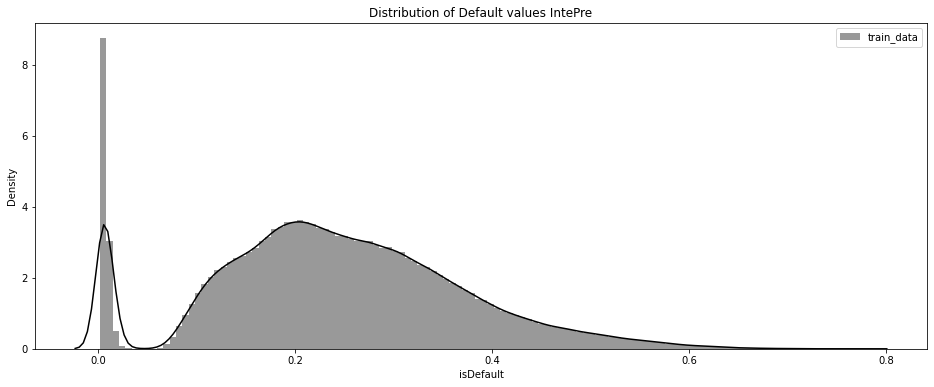

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.795364	training's binary_logloss: 0.391754	valid_1's auc: 0.792416	valid_1's binary_logloss: 0.393333
[200]	training's auc: 0.80142	training's binary_logloss: 0.387268	valid_1's auc: 0.795567	valid_1's binary_logloss: 0.390903
[300]	training's auc: 0.805473	training's binary_logloss: 0.384372	valid_1's auc: 0.796774	valid_1's binary_logloss: 0.390021
[400]	training's auc: 0.808884	training's binary_logloss: 0.381916	valid_1's auc: 0.797444	valid_1's binary_logloss: 0.389517
[500]	training's auc: 0.811921	training's binary_logloss: 0.379717	valid_1's auc: 0.797745	valid_1's binary_logloss: 0.389306
[600]	training's auc: 0.814724	training's binary_logloss: 0.3777	valid_1's auc: 0.797966	valid_1's binary_logloss: 0.389132
Early stopping, best iteration is:
[619]	training's auc: 0.815177	training's binary_logloss: 0.377372	valid_1's auc: 0.798018	valid_1's binary_logloss: 0.389094
Fold  1 AUC : 0.798018
Tr

In [28]:
import pandas as pd
train_data = pd.read_csv(PATH + 'train_public.csv')
test_data = pd.read_csv(PATH + 'test_public.csv')
sub=pd.read_csv('缩小.csv')
# sub=pd.read_csv('0.89288小于0.6复原线下0.80022.csv')
sub=sub.rename(columns={'id': 'loan_id'})
sub.loc[sub['isDefault']<0.4,'isDefault'] = 0

sub.loc[sub['isDefault']>0.7,'isDefault'] =1




nw_sub1=sub[(sub['isDefault']==0)]
nw_sub2=sub[(sub['isDefault']==1)]
nw_sub=pd.concat([nw_sub1,nw_sub2],axis=0)

# sub = sub[sub['isDefault']<0.6]
# sub.loc[sub['isDefault']>0.5,'isDefault'] = 0
# sub.loc[sub['isDefault']<0.5,'isDefault'] = 0
# nw_sub6=sub[(sub['isDefault']==0)]
# testID = nw_sub6.loan_id.tolist()
# testwei = test_public[test_public.loan_id.isin( testID )].copy()

# train_data = pd.concat([train_data,testwei])



nw_test_data=test_data.merge(nw_sub,on='loan_id',how='inner')
nw_train_data = pd.concat([train_data,nw_test_data]).reset_index(drop=True)
nw_train_data.to_csv("nw_train_public.csv",index=0)

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
train_data = pd.read_csv('nw_train_public.csv')
# submit_example = pd.read_csv('submit.csv')
test_public = pd.read_csv(PATH + 'test_public.csv')

train_inte = pd.read_csv(PATH + 'train_internet.csv')
# train_inte = train_inte[train_inte['debt_loan_ratio']<990]

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        

        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']]


def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year


cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre= train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
# IntePre = IntePre[IntePre['isDef']==1]
InteId1 = IntePre.loc[IntePre.isDefault<0.5, 'loan_id'].tolist()

# ##加入为标签
# sub.loc[sub['isDefault']<0.5,'isDefault'] = 0
# nw_sub6=sub[(sub['isDefault']==0)]
# testID = nw_sub6.loan_id.tolist()
# testwei = test_public[test_public.loan_id.isin( testID )].copy()
# testwei['isDefault'] = 0
# # testwei = testwei['isDefault'].fillna(0)

# train_data = pd.concat([train_data,testwei])
# train_data = train_data['isDefault'].fillna(0)


train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId1 )].copy()

# InteId2 = IntePre.loc[IntePre.isDefault>0.5, 'loan_id'].tolist()
# use_te2 = train_inteSame[train_inteSame.loan_id.isin( InteId2 )].copy()
# use_te3 = use_te2[use_te2['interest']<17]
# use_te = use_te[use_te['f0']<8]
 
# use_te = pd.concat([use_te1,use_te3])


# train_data = train_data[:10000]

data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)





# InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()

plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]
# for col in ['sub_class', 'work_type']:
#     del train[col]
#     del test[col]

# train = train.drop('f1',axis=1)
# test = test.drop('f1',axis=1)
del data
del train_data,test_public


y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds = train_model(train, test, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('小于0.4大于0.7二阶阈值0.5得到0.8932.csv', index=False)#0.8932

# 融合两个模型的结果

In [29]:
sub1 = pd.read_csv('缩小.csv')
sub2 = pd.read_csv('小于0.4大于0.7二阶阈值0.5得到0.8932.csv')
sub1['isDefault'] = sub1['isDefault']*0.4+sub2['isDefault']*0.6
sub1.to_csv('最终0.8936.csv',index=0)